1. We have a peptidome $p_i \in P$
2. We can sample from this peptidome $\hat{p_i} \sim P$
3. We want to create a graph $G$ that generates* $\hat{p_i}$. To do this:
    - draw $\hat{p_i} \sim P$
    - Generate peptidome from $G$. Calculate KL-divergence $\delta$ between generated peptidome and $\hat{p_i}$
    - for pair $(u_i, u_j)$ where $u_i \in u_j$ in $\hat{p_i}$. Add $lr \times \delta \times u_i$ to $w_{i,j}$ where $w_{i,j}$ is the weight of the edge between the nodes.
    - Penalize reliance on a single node by $\epsilon \times \sum_i{w_{i,j}}$ where $\epsilon$ is some penalty factor.
    


*To generate a peptidome from $G$. Let $N_T$ be the number of peptides in $\hat{p_i}$. Start from the largest peptide. The peptide is cleaved with probability $w_{i,j}$. Iterate until number of peptides $\geq N_T$.

In [1]:
def normalize_dict(d):
    s = sum(d.values())
    return {k:v/s for k,v in d.items()}

In [2]:
import numpy as np

# Generate synthetic sample
P = {"ABCD": 100, "ABC": 20, "BCD": 5, "BC":5, "CD":1, "C":0, "D":0, "AB": 50, "A": 5}
keys = list(P.keys())
values = list(P.values())
probs = [v / sum(values) for v in values]

n_sample = 50

def sample(keys, probs, n_sample):
    p_hat = np.random.choice(keys, n_sample, replace=True, p=probs)

    p_hat_dict = {k:0 for k in keys}
    for key in p_hat:
        p_hat_dict[key] += 1

    p_hat = p_hat_dict
    return p_hat
p_hat = sample(keys, probs, n_sample)
p_hat

{'ABCD': 31,
 'ABC': 6,
 'BCD': 1,
 'BC': 1,
 'CD': 0,
 'C': 0,
 'D': 0,
 'AB': 11,
 'A': 0}

In [3]:
import networkx as nx
N_T = sum(values)
G = nx.DiGraph()
G.add_nodes_from(keys)
for key1 in keys:
    for key2 in keys:
        if key1 in key2 and key1 != key2: #key 1 = ABC, key 2 = ABCD
            G.add_edge(key2, key1, weight=1)
G.edges(data=True)

OutEdgeDataView([('ABCD', 'ABC', {'weight': 1}), ('ABCD', 'BCD', {'weight': 1}), ('ABCD', 'BC', {'weight': 1}), ('ABCD', 'CD', {'weight': 1}), ('ABCD', 'C', {'weight': 1}), ('ABCD', 'D', {'weight': 1}), ('ABCD', 'AB', {'weight': 1}), ('ABCD', 'A', {'weight': 1}), ('ABC', 'BC', {'weight': 1}), ('ABC', 'C', {'weight': 1}), ('ABC', 'AB', {'weight': 1}), ('ABC', 'A', {'weight': 1}), ('BCD', 'BC', {'weight': 1}), ('BCD', 'CD', {'weight': 1}), ('BCD', 'C', {'weight': 1}), ('BCD', 'D', {'weight': 1}), ('BC', 'C', {'weight': 1}), ('CD', 'C', {'weight': 1}), ('CD', 'D', {'weight': 1}), ('AB', 'A', {'weight': 1})])

In [4]:


def generate_guess(G, keys, N_T):
    longest_key = sorted(keys, key=len)[-1]
    p_generated = {key:0 for key in keys}
    N_T_hat = 0
    while N_T_hat < N_T:
        p_generated[longest_key] += 1
        for sequence, copy_number in p_generated.items():
            if copy_number == 0:
                continue
            out_edges = G.out_edges(sequence, data=True)
            weights = np.array([weight["weight"] for _,_, weight in out_edges])
            edges_to = [edge_to for _, edge_to, _ in out_edges]
            for w, e in zip(weights, edges_to):
                p_generated[e] += w*copy_number
        N_T_hat = sum(p_generated.values())
    return p_generated

p_generated = generate_guess(G, keys, N_T)
p_generated

{'ABCD': 3,
 'ABC': 6,
 'BCD': 6,
 'BC': 26,
 'CD': 16,
 'C': 91,
 'D': 41,
 'AB': 16,
 'A': 41}

In [5]:
def KL(a, b):
    a = np.asarray(list(a)) 
    b = np.asarray(list(b)) 
    a = 1e-8 + a / np.sum(a)
    b = 1e-8 + b / np.sum(b)

    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

kl = KL(p_hat.values(), p_generated.values())

lr = 0.001 # learning rate
# time to update the graph G
def update_weights(G, kl, p_hat, p_generated, lr, verbose=False):
    p_hat = normalize_dict(p_hat)
    p_generated = normalize_dict(p_generated)
    for key in keys:
        out_edges = G.out_edges(key, data=True)
        for _, target, weight in out_edges:
            target_copy_number = p_hat[target]
            generated_target_copy_number = p_generated[target]
            diff = target_copy_number - generated_target_copy_number
            new_weight = max(0, weight["weight"] + (diff*lr*kl)) # weight cannot be less than 0
            if verbose:
                print(diff, weight, new_weight)
            # Need to add penalization here as well
            nx.set_edge_attributes(G, {(key, target):{'weight':new_weight}})
    return G
G = update_weights(G, kl, p_hat, p_generated, lr)

G.edges(data=True)

OutEdgeDataView([('ABCD', 'ABC', {'weight': 1.0002732345297727}), ('ABCD', 'BCD', {'weight': 0.99998745351649}), ('ABCD', 'BC', {'weight': 0.9997551112292684}), ('ABCD', 'CD', {'weight': 0.9998141261702227}), ('ABCD', 'C', {'weight': 0.9989428425931418}), ('ABCD', 'D', {'weight': 0.9995236983111958}), ('ABCD', 'AB', {'weight': 1.0004428443994444}), ('ABCD', 'A', {'weight': 0.9995236983111958}), ('ABC', 'BC', {'weight': 0.9997551112292684}), ('ABC', 'C', {'weight': 0.9989428425931418}), ('ABC', 'AB', {'weight': 1.0004428443994444}), ('ABC', 'A', {'weight': 0.9995236983111958}), ('BCD', 'BC', {'weight': 0.9997551112292684}), ('BCD', 'CD', {'weight': 0.9998141261702227}), ('BCD', 'C', {'weight': 0.9989428425931418}), ('BCD', 'D', {'weight': 0.9995236983111958}), ('BC', 'C', {'weight': 0.9989428425931418}), ('CD', 'C', {'weight': 0.9989428425931418}), ('CD', 'D', {'weight': 0.9995236983111958}), ('AB', 'A', {'weight': 0.9995236983111958})])

In [6]:
# The loop

lr = 0.1

generated = {}
kls = []
# given p_hat
for i in range(500):
    p_hat = sample(keys, probs, n_sample)
    p_generated = generate_guess(G, keys, N_T)
    generated[i] = p_generated
    kl = KL(p_hat.values(), p_generated.values())
    G = update_weights(G, kl, p_hat, p_generated, lr)
    kls.append(kl)
    weight_sum = sum([weight["weight"] for _,_,weight in G.edges(data=True)])

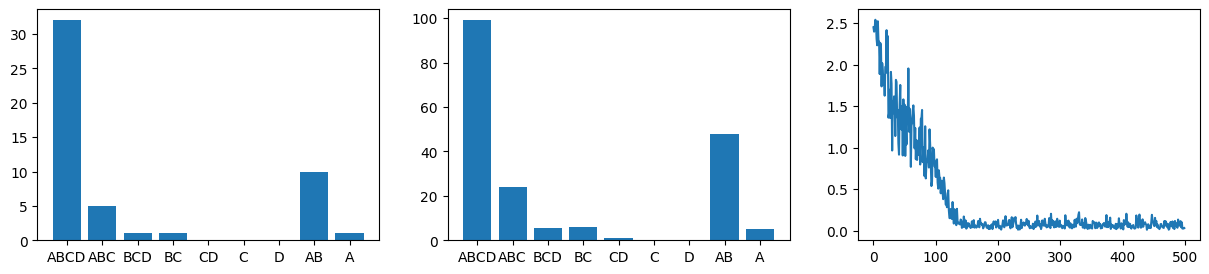

In [7]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,3, figsize=(15,3))
p_generated = generated[list(generated.keys())[-1]]
axs[0].bar(p_hat.keys(), p_hat.values())
axs[1].bar(p_generated.keys(), p_generated.values())
axs[2].plot(kls)
plt.show()